In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
from astropy.table import Table, join,join_skycoord
import GCRCatalogs as gcr
import matplotlib.pyplot as plt
import GCRCatalogs as gcr
from scipy.optimize import minimize
from astropy.coordinates import SkyCoord
import astropy.units as u
plt.style.use('MNRAS.mplstyle')

# h = 0.71
zmax = 0.35
zmin = 0.2
file_path = r"/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/Data/"

file_path2 = r"global/homes/k/kamau/SE-CLMM-LSSTDESC/project-1/Notebooks/skysim5000/Images"

In [2]:
## Sigma and DS profile
SOD = pd.read_pickle(file_path + 'WL-Signal/skysim-full-2152757-1.1.1.csv') #Table.read(file_path + 'halos/Skysim_SOD_Filter/skysim_0.2-1_1.1.1_SOD.dat', format='ascii')
print(len(SOD))
SOD = SOD[SOD['baseDC2/sod_halo_mass']>0]
print(len(SOD))
SOD = SOD[(SOD['redshift']>=zmin) & (SOD['redshift']<zmax)]
print(len(SOD))

2152757
2149934
164429


In [3]:
'{:e}'.format(SOD['baseDC2/sod_halo_mass'].min())

'1.857190e+12'

In [4]:
cluster_halo = pd.read_pickle(file_path + 'halos/halos_redmapper_mthd2.csv')# /halos/halos_redmapper.csv
cluster_halo = Table.from_pandas(cluster_halo)
print(len(cluster_halo))
# cluster_halo = cluster_halo.to_pandas()
cluster_halo = cluster_halo[(cluster_halo['redshift_1']>=zmin) & (cluster_halo['redshift_1']<=zmax)]
# cluster_halo = cluster_halo.reset_index(drop=True)
print(len(cluster_halo))
M200c = cluster_halo['baseDC2/sod_halo_mass'] #cluster_halo['baseDC2/sod_halo_mass'] #sigma_ds_profile['baseDC2/sod_halo_mass']
lam = cluster_halo['richness']
print(len(M200c), len(lam))

37798
4682
4682 4682


In [5]:
'{:e}'.format(cluster_halo['baseDC2/sod_halo_mass'].min())

'5.216763e+12'

In [6]:
from colossus.cosmology import cosmology
skysim = gcr.load_catalog('skysim5000_v1.1.1')
gcosmology = skysim.cosmology
params = {'flat': True, 'H0': gcosmology.H0.value, 'Om0': gcosmology.Om0, 'Ob0': gcosmology.Ob0,
         'sigma8': gcosmology.sigma8, 'ns':gcosmology.n_s} # - gcosmology.Ob0
cosmo = cosmology.setCosmology('cosmo', params)

# vol_hiMpc3 = (5000/(4*np.pi*((180/np.pi)**2)))*(4*np.pi/3)*(self.cosmo.comovingDistance(z_max=self.redshift_max)**3 - self.cosmo.comovingDistance(z_max=self.redshift_min)**3)

In [7]:
vol_hiMpc3 = (5000/(4*np.pi*((180/np.pi)**2)))*(4*np.pi/3)*((cosmo.comovingDistance(z_max=zmax))**3 - (cosmo.comovingDistance(z_max=zmin))**3) 

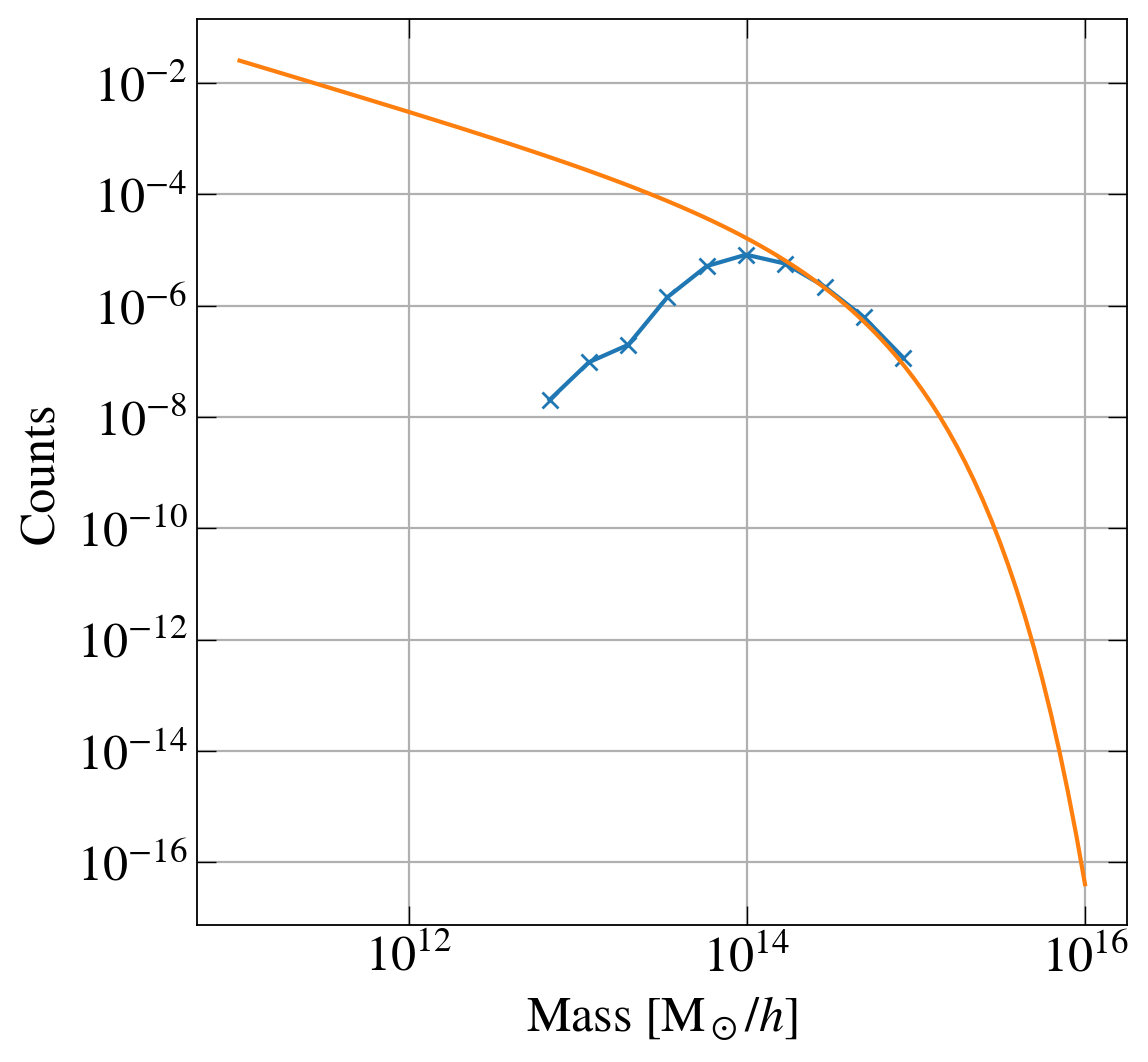

In [8]:
# # check the mass function
lnM_all = np.array(np.log(M200c))
counts, bins = np.histogram(lnM_all)
bins_mid = (bins[1:]+bins[:-1])/2.
counts = counts/(bins[1]-bins[0])
vol = vol_hiMpc3 #383945373.5961392 # 3167776723.771067 #1500**3  #??
plt.plot(np.exp(bins_mid), (counts/vol), marker='x')
plt.yscale('log')


from colossus.lss import mass_function
redshift =cluster_halo['redshift'].mean()
M_plot = np.logspace(11,16,100)
mfunc_200c = mass_function.massFunction(M_plot, redshift, q_out='dndlnM', 
    mdef = '200c', model = 'tinker08')
plt.plot(M_plot, mfunc_200c)

from scipy.interpolate import interp1d
lnMF_interp = interp1d(np.log(M_plot), np.log(vol*mfunc_200c))
plt.xlabel('Mass [M$_\odot/h$]')
plt.ylabel('Counts')
plt.xscale('log')

In [9]:
print('{:e}'.format(cluster_halo['baseDC2/sod_halo_mass'].min()))
print('{:e}'.format(cluster_halo['halo_mass'].min()))
print('{}'.format(cluster_halo['richness'].min()))

5.216763e+12
1.059863e+13
20.00348472595215


29.28289823306635


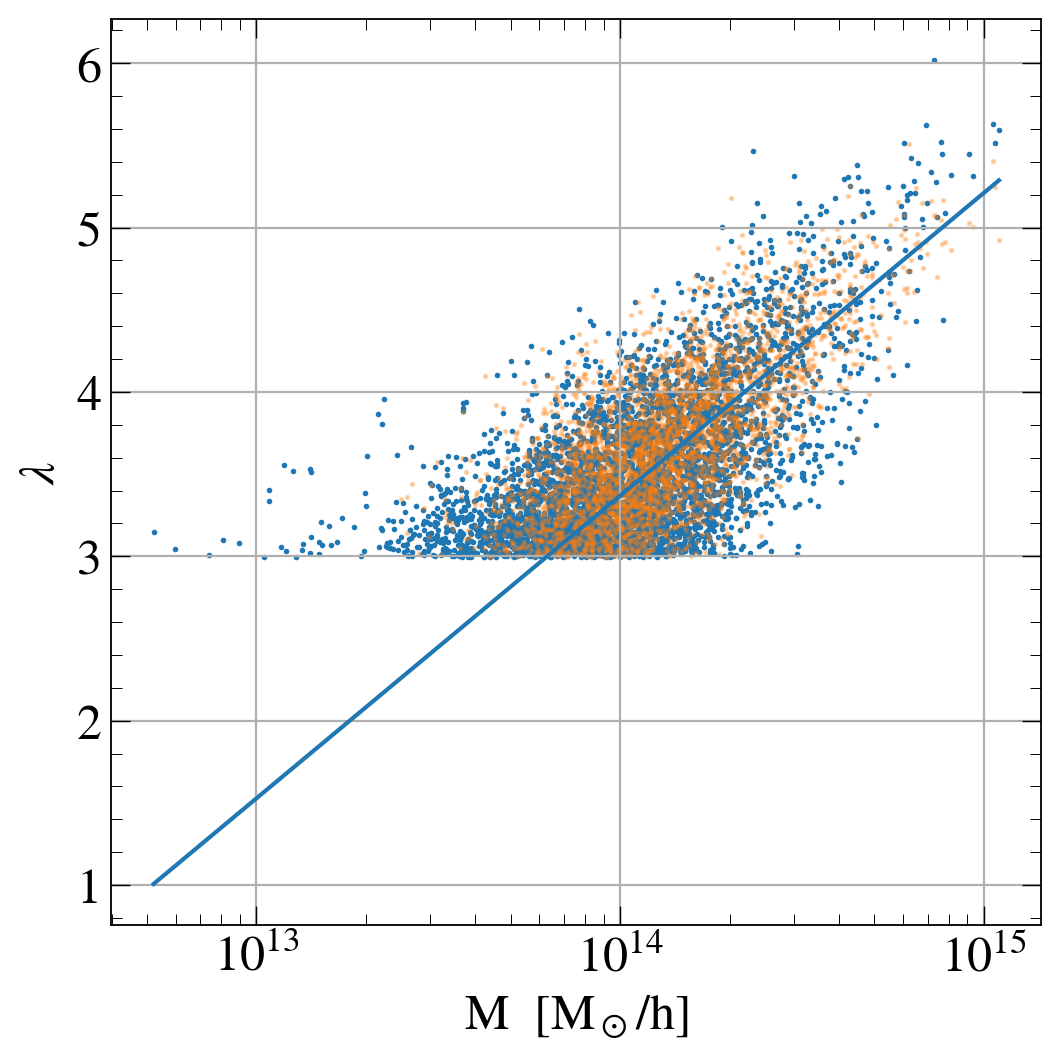

In [10]:
# plot richness-mass relation with a lambda 20 cut
lnMpivot = np.log(3e14)
lnlamth = np.log(20)

lnlam = np.log(lam)
ndata = len(lnM_all)


def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam):
    plt.scatter(np.exp(lnM_all), lnlam, s=1)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    plt.scatter(np.exp(lnM_mc), lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(min(lnM_all), max(lnM_all))
    print(lnM_plot.min())
    plt.plot(np.exp(lnM_plot), intercept + slope * (lnM_plot - lnMpivot))
    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel(r'M  [$\rm M_\odot/h$]')
    plt.ylabel(r'$\lambda$')
    plt.xscale('log')

# make a guess for starting points
plot_data_vs_monte_carlo_points(intercept=np.log(70),
    slope=0.8, sigma0=0.3, qlam=-0.09)

In [11]:
# Maximum likelihood! 
def negative_lnlikelihood_single(para, lnlam, lnM):
    intercept, slope, sigma0, qlam = para
    lnlam_mean = intercept + slope * (lnM - lnMpivot) 
    sig = sigma0 + qlam * (lnM - lnMpivot) 
    sig = max(sig, 1e-4) 
    scatter_sqr = sig**2
    output = (lnlam-lnlam_mean)**2/(2*scatter_sqr) 
    output += 0.5 * np.log(2*np.pi*scatter_sqr) 
    output += -lnMF_interp(lnM)
    return output

def negative_lnlikelihood_total(para, lnlam, lnM):
    intercept, slope, sigma0, qlam = para

    tot = 0
    for i in range(ndata):
        tot += negative_lnlikelihood_single(para, lnlam[i], lnM[i])
  
    def p_lnlam_lnM(lnlam, lnM):
        lnlam_mean = intercept + slope * (lnM - lnMpivot) 
        sig = sigma0 + qlam * (lnM - lnMpivot) 
        sig[sig < 1e-4] = 1e-4 #max(sig,1e-4)
        scatter_sqr = sig**2
        out = np.exp(-(lnlam - lnlam_mean)**2/2/scatter_sqr)
        out *= 1/np.sqrt(2*np.pi*scatter_sqr)
        return out

    lnM_plot = np.linspace(min(lnM_all), max(lnM))
    def integration1(lnlam):
        y = p_lnlam_lnM(lnlam, lnM_plot) * np.exp(lnMF_interp(lnM_plot))
        return np.trapz(y, x=lnM_plot)

    lnlam_plot = np.linspace(lnlamth, max(lnlam))
    intgration1_list = []
    for lnlam in lnlam_plot:
        intgration1_list.append(integration1(lnlam))
    Ndet = np.trapz(intgration1_list, x=lnlam_plot)
    tot += Ndet
    return tot

x0 = (np.log(70), 0.8, 0.3, -0.09)
bounds = ((3,5),(0.5,1.2),(0.02, 0.5), (-0.2,0))
res = minimize(negative_lnlikelihood_total, x0, args=(lnlam, lnM_all), bounds=bounds)
# print(res)
# negative_lnlikelihood_total(x0,lnlam, lnM_all)

29.28289823306635


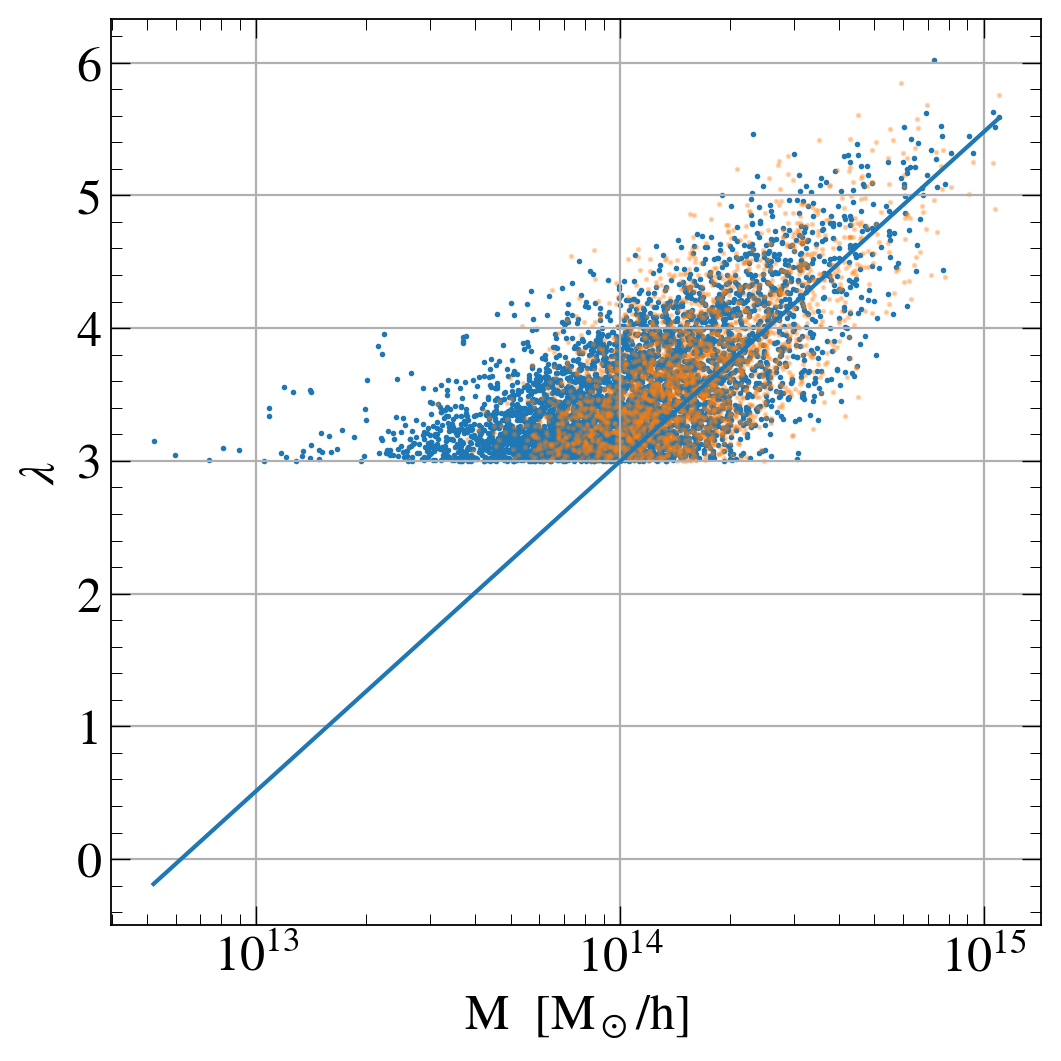

In [12]:
plot_data_vs_monte_carlo_points(intercept=res.x[0],
    slope=res.x[1], sigma0=res.x[2], qlam=res.x[3])

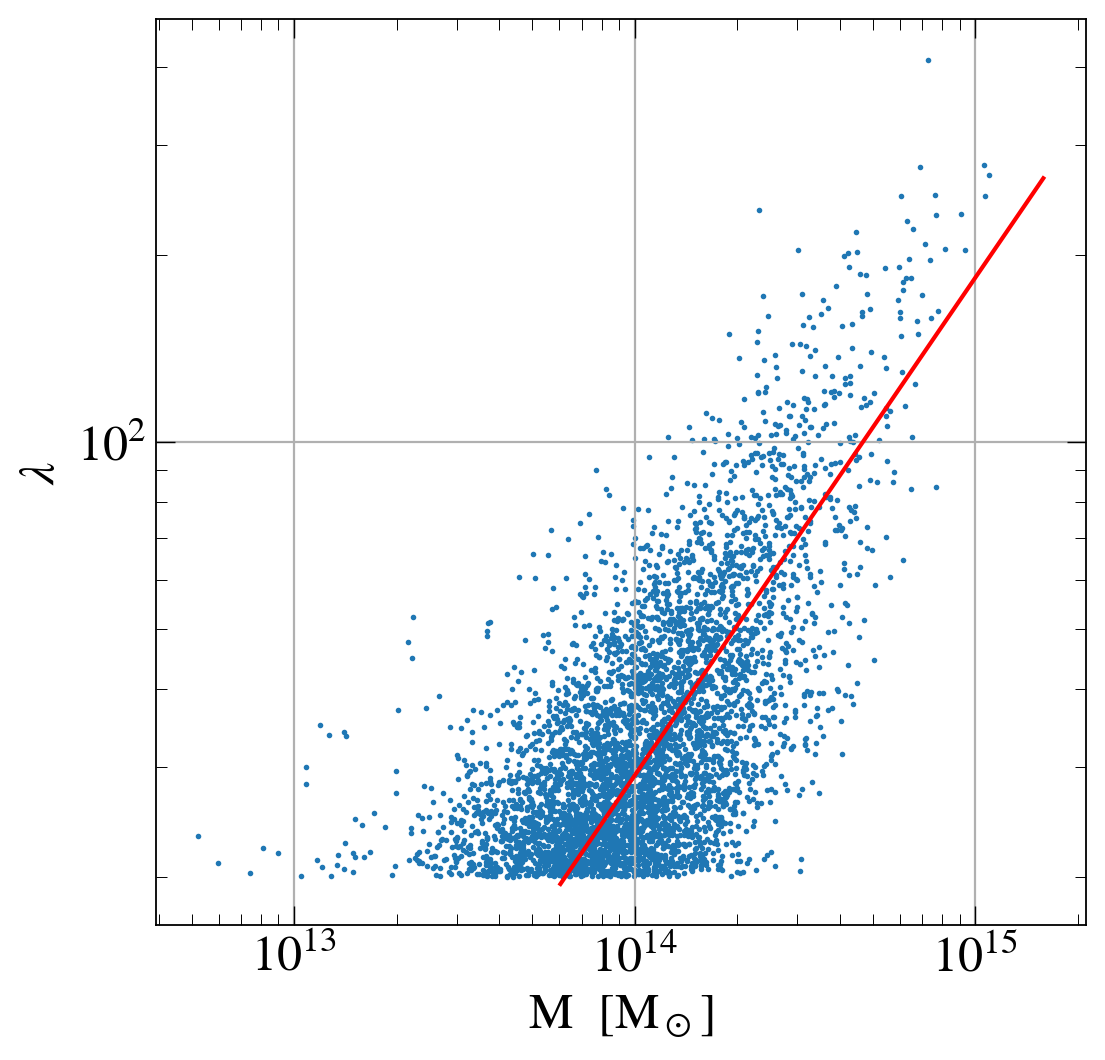

In [13]:
# plot richness-mass relation with a lambda 20 cut
lnMpivot = np.log(3e14)
lnlamth = np.log(20)

lnlam = np.log(lam)
ndata = len(lnM_all)


def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam):
    plt.scatter(np.exp(lnM_all), np.exp(lnlam), s=1)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    plt.plot(np.exp(lnM_plot), lambd, c='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'M  [$\rm M_\odot$]')
    plt.ylabel(r'$\lambda$')

# make a guess for starting points
plot_data_vs_monte_carlo_points(intercept=np.log(70),
    slope=0.8, sigma0=0.3, qlam=-0.09)

# plt.savefig('Images/mass_richness.png', facecolor='white')

[ 4.18399898  1.07806524  0.45067785 -0.05292206]
[ 4.18715248  1.06788109  0.44735502 -0.0553394 ]
[ 4.16624697  1.05082964  0.47949718 -0.04075503]
[ 4.12691354  1.00757403  0.48106055 -0.02361107]
[ 4.11330338  0.99434151  0.4812421  -0.01391778]


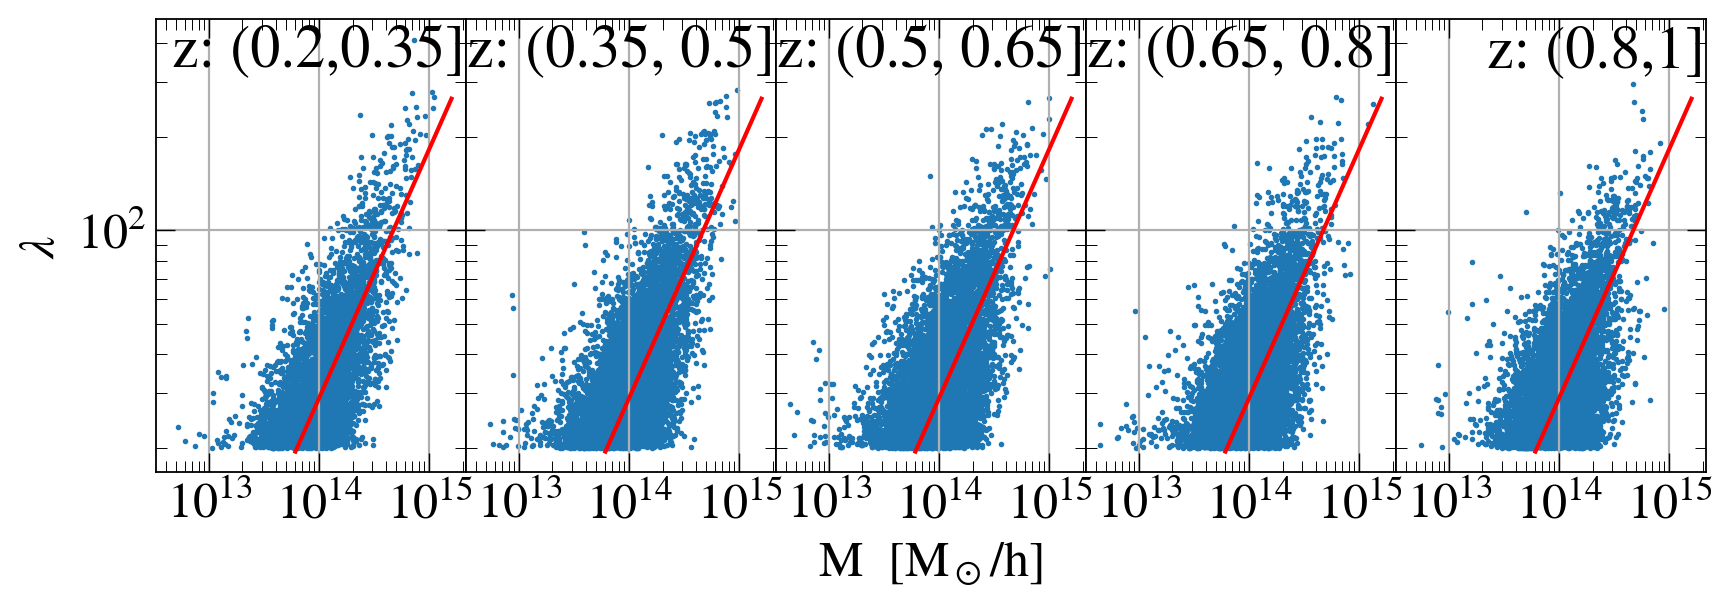

In [24]:
cluster_halo2 = pd.read_pickle(file_path + 'halos/halos_redmapper_mthd2.csv')
# cluster_halo2 = cluster_halo2.to_pandas()
cluster_halo2 = cluster_halo2[(cluster_halo2['redshift']<=1)]  # & (cluster_halo2['baseDC2/sod_halo_mass']>=1e13)
cluster_halo2 = cluster_halo2.reset_index(drop=True)

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65), (0.65, 0.8), (0.8,1)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]', '(0.8,1]']
cluster_halo2['redshift_range'] = pd.cut(cluster_halo2['redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
# grouped = cluster_halo3.groupby('redshift_range')

# Group by redshift_range
grouped_data = cluster_halo2.groupby('redshift_range')


# Create four subplots
fig, axs = plt.subplots(1, 5,figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()

def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam, lnM_all, lnlam):
    ax.scatter(np.exp(lnM_all), np.exp(lnlam), s=1)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    ax.plot(np.exp(lnM_plot), lambd, c='r')

# Iterate over the groups and plot the data
for i, (group, data) in enumerate(grouped_data):
    ax = axs[i]  # Select the current subplot
    # make a guess for starting points
    mass = np.array(np.log(data['baseDC2/sod_halo_mass']))
    richness = np.array(np.log(data['richness']))
    # print(richness.shape, type(richness))
    # print(mass.shape, type(mass))
    res = minimize(negative_lnlikelihood_total, x0, args=(richness, mass), bounds=bounds)
    print(res.x)
    plot_data_vs_monte_carlo_points(intercept=np.log(70), slope=0.8, sigma0=0.3, qlam=-0.09, lnM_all=mass, lnlam=richness)
    # print(res)

    # Set the title inside the subplot
    title = f'z: {group}'
    title_y = 0.859 if i > 1 else 0.859  # Adjust the y position for the last row
    ax.set_title(title,  loc='right', y=title_y)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axs[[2]]:
    ax.set_xlabel(r'M  [$ \rm M_\odot/h$]')
    
for ax in axs[[0]]:
    ax.set_ylabel('$\lambda$')

filep = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/'
plt.savefig(filep + 'Images/skysim_mass-richness.png', facecolor='white')
plt.show()

[ 4.18399898  1.07806524  0.45067785 -0.05292206]
[ 4.18715248  1.06788109  0.44735502 -0.0553394 ]
[ 4.16624697  1.05082964  0.47949718 -0.04075503]
[ 4.12691354  1.00757403  0.48106055 -0.02361107]
[ 4.11330338  0.99434151  0.4812421  -0.01391778]


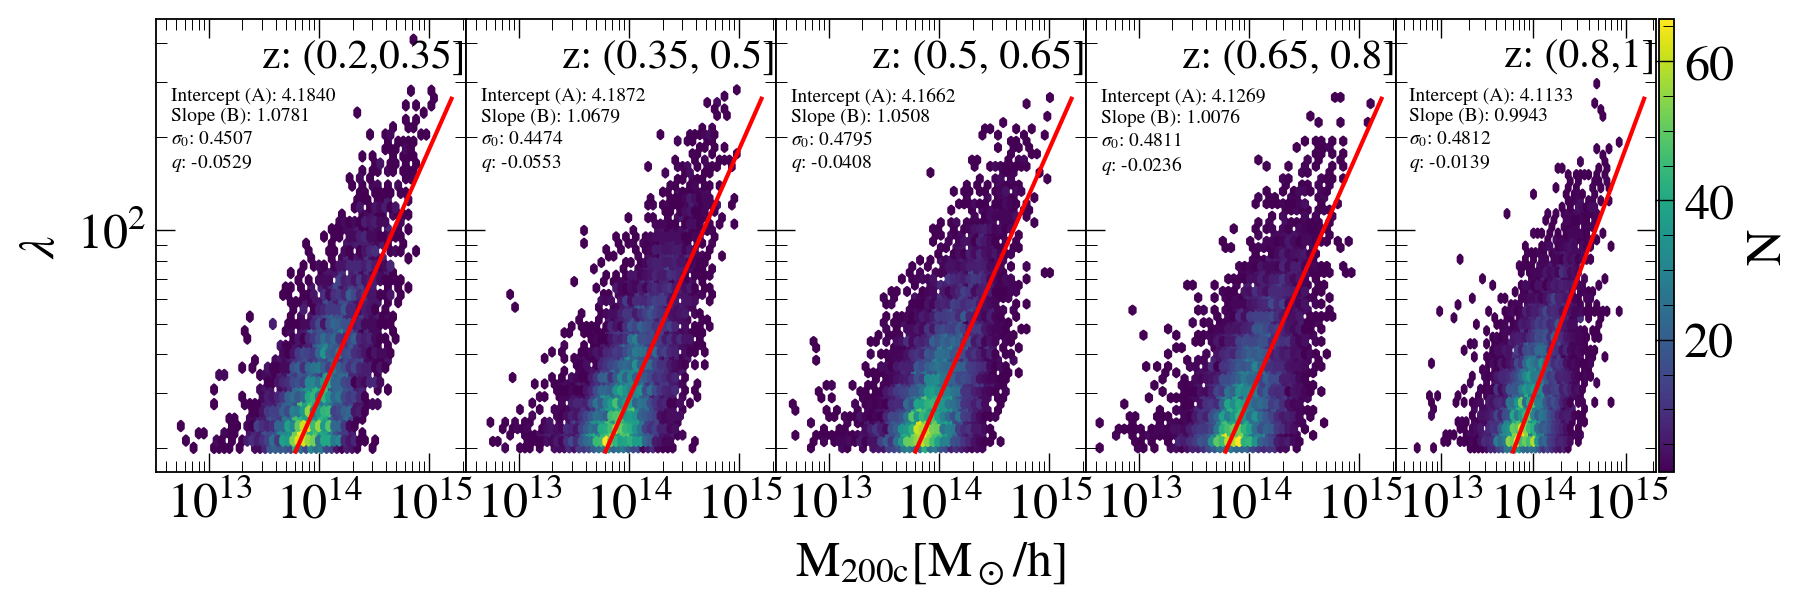

In [25]:
cluster_halo2 = pd.read_pickle(file_path + 'halos/halos_redmapper_mthd2.csv')
# cluster_halo2 = cluster_halo2.to_pandas()
cluster_halo2 = cluster_halo2[(cluster_halo2['redshift']<=1)]  # & (cluster_halo2['baseDC2/sod_halo_mass']>=1e13)
cluster_halo2 = cluster_halo2.reset_index(drop=True)

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65), (0.65, 0.8), (0.8,1)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]', '(0.8,1]']
cluster_halo2['redshift_range'] = pd.cut(cluster_halo2['redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]], labels=zlabels)
# grouped = cluster_halo3.groupby('redshift_range')

# Group by redshift_range
grouped_data = cluster_halo2.groupby('redshift_range')


# Create four subplots
fig, axs = plt.subplots(1, 5,figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()

def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam, lnM_all, lnlam):
    hb = ax.hexbin(np.exp(lnM_all),np.exp(lnlam), gridsize=50, cmap='viridis', mincnt=1, xscale='log', yscale='log')
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    ax.plot(np.exp(lnM_plot), lambd, c='r', label='best-fit')
    return hb

# Iterate over the groups and plot the data
for i, (group, data) in enumerate(grouped_data):
    ax = axs[i]  # Select the current subplot
    # make a guess for starting points
    mass = np.array(np.log(data['baseDC2/sod_halo_mass']))
    richness = np.array(np.log(data['richness']))
    # print(richness.shape, type(richness))
    # print(mass.shape, type(mass))
    res = minimize(negative_lnlikelihood_total, x0, args=(richness, mass), bounds=bounds)
    print(res.x)
    intercept = res.x[0]
    slope = res.x[1]
    sigma0 = res.x[2]
    qlam = res.x[3]
    
    hb = plot_data_vs_monte_carlo_points(intercept=np.log(70), slope=0.8, sigma0=0.3, qlam=-0.09, lnM_all=mass, lnlam=richness)

        
    # Add best-fit parameters as text
    textstr = '\n'.join((
        r'Intercept (A): %.4f' % (intercept),
        r'Slope (B): %.4f' % (slope),
        r'$\sigma_0$: %.4f' % (sigma0),
        r'$q$: %.4f' % (qlam)))
    
    props = dict(boxstyle='round', facecolor='white', alpha=0)
    ax.text(0.05, 0.85, textstr, transform=ax.transAxes, fontsize=7,
            verticalalignment='top', bbox=props)
    
    # Set the title inside the subplot
    title = f'z: {group}'
    title_y = 0.859 if i > 1 else 0.859  # Adjust the y position for the last row
    ax.set_title(title,  loc='right', y=title_y, fontsize=15)
    ax.grid(visible=False)
    
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    
# Add color bar at the end of the plot on the right
cbar = fig.colorbar(hb, ax=axs[4], location='right', pad=0.01, aspect=30)
cbar.set_label(r'N')


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

for ax in axs[[2]]:
    ax.set_xlabel(r'$ \rm M_{200c} [ M_\odot/h$]')
    
for ax in axs[[0]]:
    ax.set_ylabel('$\lambda$')
    
# plt.legend()

filep = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/'
plt.savefig(filep + 'Images/skysim_mass-richness_hex.png', facecolor='white')
# plt.grid()
plt.show()

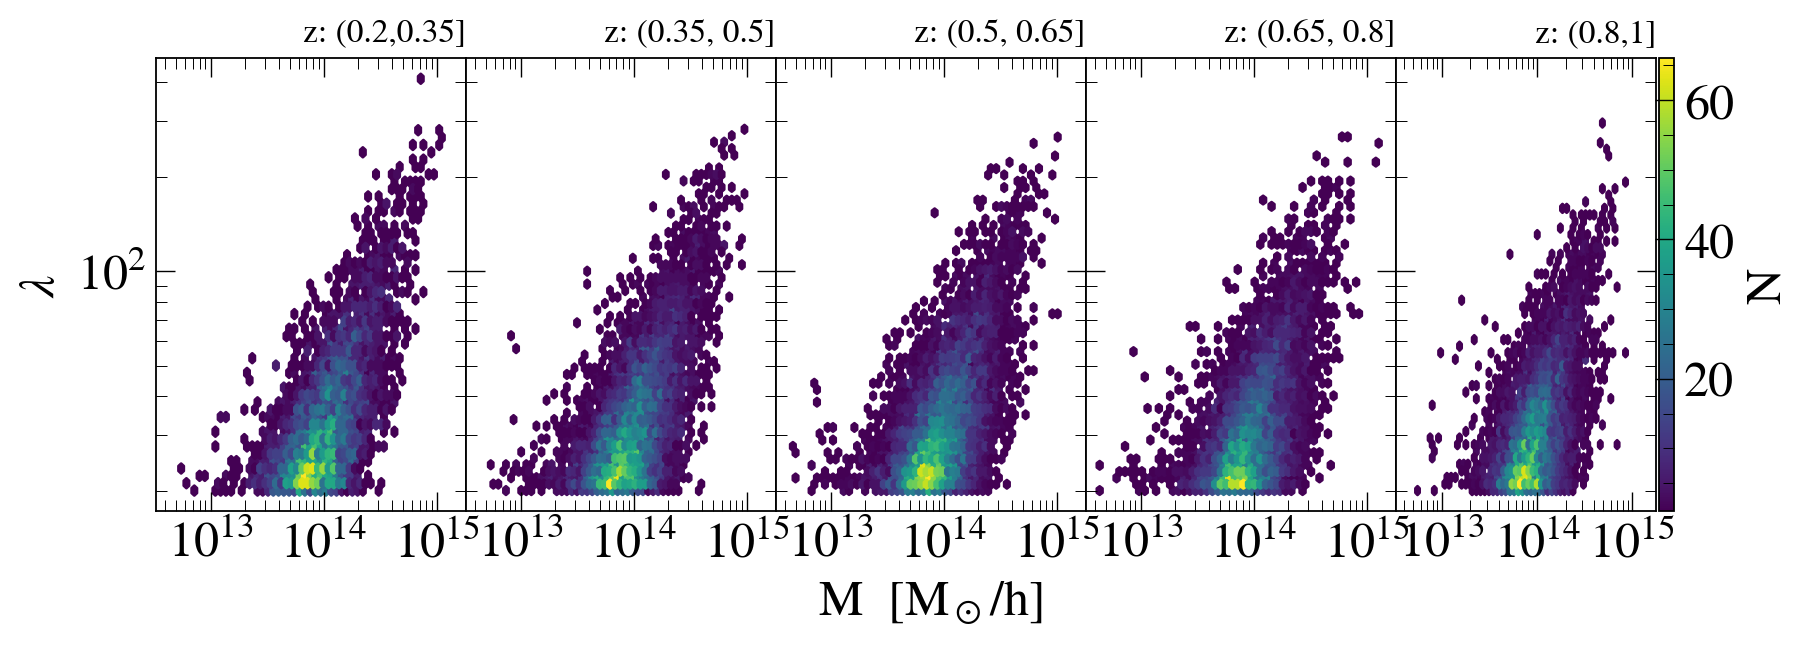

In [20]:
# Create four subplots
fig, axs = plt.subplots(1, 5,figsize=(10, 3), sharex=True, sharey=True)
axs = axs.flatten()
# Define a plotting function
def plot_data_vs_monte_carlo_points(lnM_all, lnlam):
    hb = ax.hexbin(lnM_all,lnlam, gridsize=50, cmap='viridis', mincnt=1, xscale='log', yscale='log')
    return hb
# Iterate over the groups and plot the data
for i, (group, data) in enumerate(grouped_data):
    ax = axs[i]  # Select the current subplot
    mass = data['baseDC2/sod_halo_mass']
    richness = data['richness']
    hb = plot_data_vs_monte_carlo_points(lnM_all=mass, lnlam=richness)
    
    # Set the title inside the subplot
    title = f'z: {group}'
    ax.set_title(title, loc='right', fontsize=12)
    ax.grid()
    
#     ax.set_xscale('log')
#     ax.set_yscale('log')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0, wspace=0)

# Add color bar at the end of the plot on the right
cbar = fig.colorbar(hb, ax=axs[4], location='right', pad=0.01, aspect=30)
cbar.set_label('N')

# Set axis labels
axs[2].set_xlabel(r'M  [$ \rm M_\odot/h$]')
axs[0].set_ylabel('$\lambda$')

# Show the plot

plt.show()

# Extracted halos filtered on SOD mass

In [36]:
sky_02_1 = pd.read_pickle(file_path + 'WL-Signal/skysim-full-2152757-1.1.1.csv')
sky_02_1 = sky_02_1[sky_02_1['baseDC2/sod_halo_mass']>0]#Table.read(file_path + 'halos/Skysim_SOD_Filter/skysim_0.2-1_1.1.1_SOD.dat', format='ascii')
print(len(sky_02_1))

2149934


In [37]:
len(sky_02_1[sky_02_1['baseDC2/sod_halo_mass']<=0]), len(sky_02_1[sky_02_1['baseDC2/sod_halo_mass']>0]), len(sky_02_1[sky_02_1['baseDC2/sod_halo_mass']>=1e13])

(0, 2149934, 1280689)

In [38]:
sky_02_1_2 = sky_02_1[(sky_02_1['redshift']>=0.2) & (sky_02_1['redshift']<=0.95)]
# sky_02_1_2 = Table.from_pandas(sky_02_1_2)
# sigma_ds_profile2 = sigma_ds_profile2.reset_index(drop=True)

zranges = [(0.2, 0.21), (0.35, 0.36), (0.5, 0.51), (0.65, 0.66), (0.8, 0.81)]
zlabels = ['(0.2,0.21]', '(0.35, 0.36]', '(0.5, 0.51]', '(0.65, 0.66]', '(0.8, 0.81]']
sky_02_1_2['redshift_range'] = pd.cut(sky_02_1_2['redshift'], bins=pd.IntervalIndex.from_tuples(zranges), labels=zlabels)

# sky_02_1_2 = sky_02_1_2.to_pandas()
# sky_02_1_2 = sky_02_1_2.dropna()

<ipython-input-38-ce31b0c46de3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sky_02_1_2['redshift_range'] = pd.cut(sky_02_1_2['redshift'], bins=pd.IntervalIndex.from_tuples(zranges), labels=zlabels)


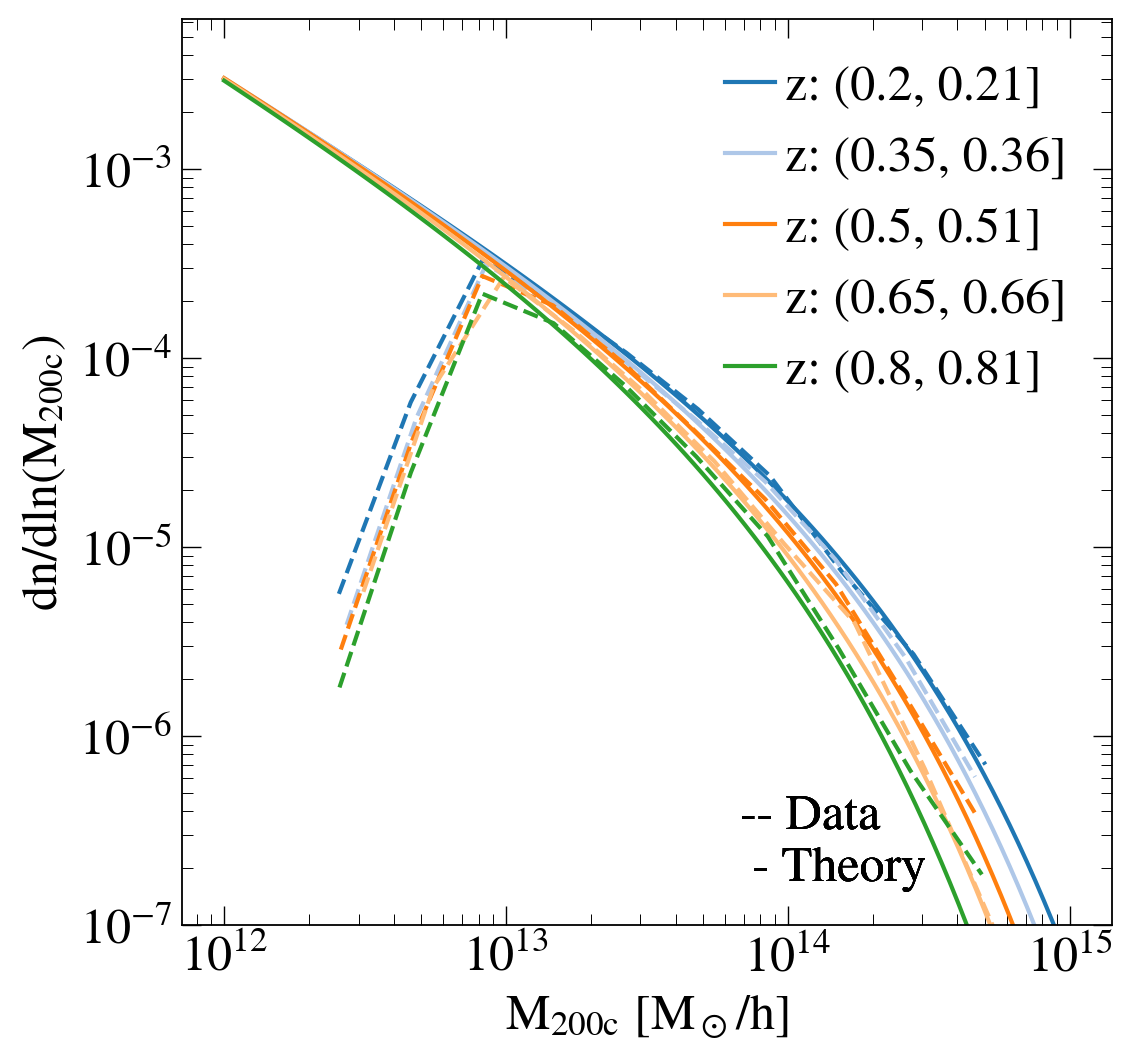

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import re
from colossus.lss import mass_function

grouped_data = sky_02_1_2.groupby('redshift_range')

# Create a color map
color_map = plt.cm.get_cmap('tab20')  # Choose a colormap

# Iterate over the groups and plot the data
for idx, (group, data) in enumerate(grouped_data):
    group = str(group)
    zmin = float(re.findall(r'\d+\.\d+', group)[0])
    zmax = float(re.findall(r'\d+\.\d+', group)[1])
    vol_hiMpc3 = (5000 / (4 * np.pi * ((180 / np.pi) ** 2))) * (4 * np.pi / 3) * (
            (cosmo.comovingDistance(z_max=zmax)) ** 3 - (cosmo.comovingDistance(z_max=zmin)) ** 3)
    M200c = data['baseDC2/sod_halo_mass']
    lnM_all = np.array(np.log(M200c))
    counts, bins = np.histogram(lnM_all)
    bins_mid = (bins[1:] + bins[:-1]) / 2.
    counts = counts / (bins[1] - bins[0])
    vol = vol_hiMpc3
    color = color_map(idx % color_map.N)  # Get a color from the colormap

    plt.plot(np.exp(bins_mid), (counts / vol), color=color, linestyle='--')

    redshift = data['redshift'].mean() #data['redshift'].max()+0.035
    M_plot = np.logspace(12, 15, 100)
    mfunc_200c = mass_function.massFunction(M_plot, redshift, q_out='dndlnM',
                                            mdef='200c', model='tinker08')
    plt.plot(M_plot, mfunc_200c, color=color, label='z')

    # Add text description
    text = f'-- Data \n - Theory'
    plt.text(0.6, 0.05, text, transform=plt.gca().transAxes)

# Set custom labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = [f'{label}: {group}' for label, group in zip(labels, grouped_data.groups.keys())]


plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-7)
plt.xlabel('$\mathrm{M_{200c} ~ [M_\odot/h}]$')
plt.ylabel('$\mathrm{dn/d\ln(M_{200c}})$')
plt.legend(handles, custom_labels, loc='upper right', frameon=False, handletextpad=0.2, 
                        columnspacing=0.3,
                        markerscale=0.8,  # Scale down the size of the markers
                        handlelength=1)
plt.grid(visible=False)
filep = r'/global/u1/k/kamau/SE-CLMM-LSSTDESC/project-1/'
plt.savefig(filep+'Images/skysim_HaloMassFxn.png', facecolor='white')
plt.show()


In [53]:
redmapper = gcr.load_catalog('skysim5000_v1.1.1_redmapper_v0.8.5')

In [54]:
quantities = np.sort(redmapper.list_all_quantities())
print(len(quantities))

# Cluster quantities
cl_quantities = [q for q in quantities if 'member' not in q]
print(cl_quantities, len(cl_quantities))

# Member quantities
me_quantities = [q for q in quantities if 'member' in q]
print(me_quantities, len(me_quantities))

51
['cluster_id', 'dec', 'dec_cen_0', 'dec_cen_1', 'dec_cen_2', 'dec_cen_3', 'dec_cen_4', 'id_cen_0', 'id_cen_1', 'id_cen_2', 'id_cen_3', 'id_cen_4', 'maskfrac', 'p_cen_0', 'p_cen_1', 'p_cen_2', 'p_cen_3', 'p_cen_4', 'ra', 'ra_cen_0', 'ra_cen_1', 'ra_cen_2', 'ra_cen_3', 'ra_cen_4', 'redshift', 'redshift_err', 'redshift_true_cg', 'richness', 'richness_err', 'scaleval'] 30
['cluster_id_member', 'dec_member', 'id_member', 'mag_g_lsst_member', 'mag_i_lsst_member', 'mag_r_lsst_member', 'mag_y_lsst_member', 'mag_z_lsst_member', 'magerr_g_lsst_member', 'magerr_i_lsst_member', 'magerr_r_lsst_member', 'magerr_y_lsst_member', 'magerr_z_lsst_member', 'p_member', 'pfree_member', 'ra_member', 'redshift_true_member', 'refmag_err_member', 'refmag_member', 'theta_i_member', 'theta_r_member'] 21


In [59]:
redmapper_cl = Table(redmapper.get_quantities(['cluster_id','ra','dec','redshift','richness','clusters/z_lambda','clusters/mem_match_id']))
print(len(redmapper_cl))
redmapper_cl = redmapper_cl[(redmapper_cl['redshift']>=0.2) & (redmapper_cl['redshift']<=1)]
print(len(redmapper_cl))

46491
38630


In [60]:
## Halos extracted based on FOF mass definition
# sigma_ds_profile = pd.read_pickle(file_path + 'WL-Signal/skysim-full-2152757-1.1.1.csv')

In [65]:
sky_02_1['sc'] = SkyCoord(sky_02_1['ra'], sky_02_1['dec'], unit='deg')
redmapper_cl['sc'] = SkyCoord(redmapper_cl['ra'], redmapper_cl['dec'], unit='deg')

In [68]:
perfect_match = join(redmapper_cl, sky_02_1, join_type='inner', keys=['dec','ra'])
print(len(perfect_match))

33345


In [69]:
'{:e}'.format(perfect_match['baseDC2/sod_halo_mass'].min()), '{:e}'.format(perfect_match['halo_mass'].min())

('1.934804e+12', '2.699057e+12')

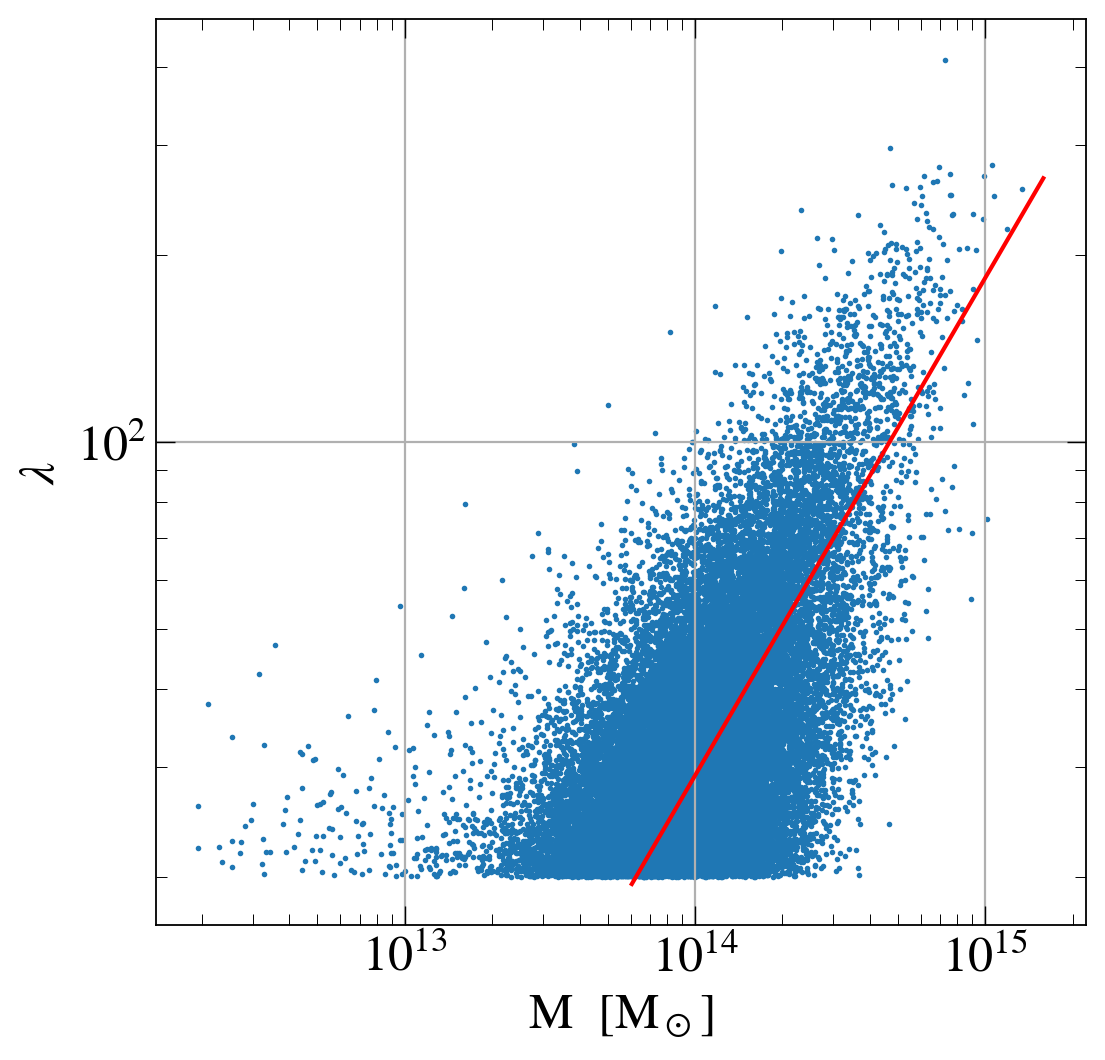

In [70]:
# plot richness-mass relation with a lambda 20 cut
lnMpivot = np.log(3e14)
lnlamth = np.log(20)

lnM_all = np.log(perfect_match['baseDC2/sod_halo_mass'])
lnlam = np.log(perfect_match['richness'])
ndata = len(lnM_all)


def plot_data_vs_monte_carlo_points(intercept, slope, sigma0, qlam):
    plt.scatter(np.exp(lnM_all), np.exp(lnlam), s=1)
    mean_lnlam = intercept + slope * (lnM_all - lnMpivot)
    sig = sigma0 + qlam * (lnM_all - lnMpivot) 
    sig[sig < 0] = 1e-4
    from scipy.stats import norm
    lnlam_mc = norm.rvs(loc=mean_lnlam, scale=sig)
    sel = lnlam_mc > np.log(20)
    lnM_mc = lnM_all[sel]
    lnlam_mc = lnlam_mc[sel]
    # plt.scatter(lnM_mc, lnlam_mc, s=1, alpha=0.3)
    
    lnM_plot = np.linspace(25, 35)
    lambd = np.exp(intercept + slope * (lnM_plot - lnMpivot))
    sel = lambd>=19
    lambd = lambd[sel]
    lnM_plot = lnM_plot[sel]
    plt.plot(np.exp(lnM_plot), lambd, c='r')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'M  [$\rm M_\odot$]')
    plt.ylabel(r'$\lambda$')

# make a guess for starting points
plot_data_vs_monte_carlo_points(intercept=np.log(70),
    slope=0.8, sigma0=0.3, qlam=-0.09)

# plt.savefig('Images/mass_richness.png', facecolor='white')

# Extracted halos on FoF mass

In [40]:
sigma_ds_profile2 = pd.read_pickle(file_path + 'WL-Signal/skysim-full-2152757-1.1.1.csv')
sigma_ds_profile2 = sigma_ds_profile2[(sigma_ds_profile2['redshift']<=0.95) & (sigma_ds_profile2['baseDC2/sod_halo_mass']>0)]
sigma_ds_profile2 = sigma_ds_profile2.reset_index(drop=True)

zranges = [(0.2,0.35), (0.35, 0.5), (0.5, 0.65), (0.65, 0.8), (0.8,0.95)]
zlabels = ['(0.2,0.35]', '(0.35, 0.5]', '(0.5, 0.65]', '(0.65, 0.8]','(0.8,0.95]']
sigma_ds_profile2['redshift_range'] = pd.cut(sigma_ds_profile2['redshift'], bins=[r[0] for r in zranges] + [zranges[-1][-1]],
                                            labels=zlabels)

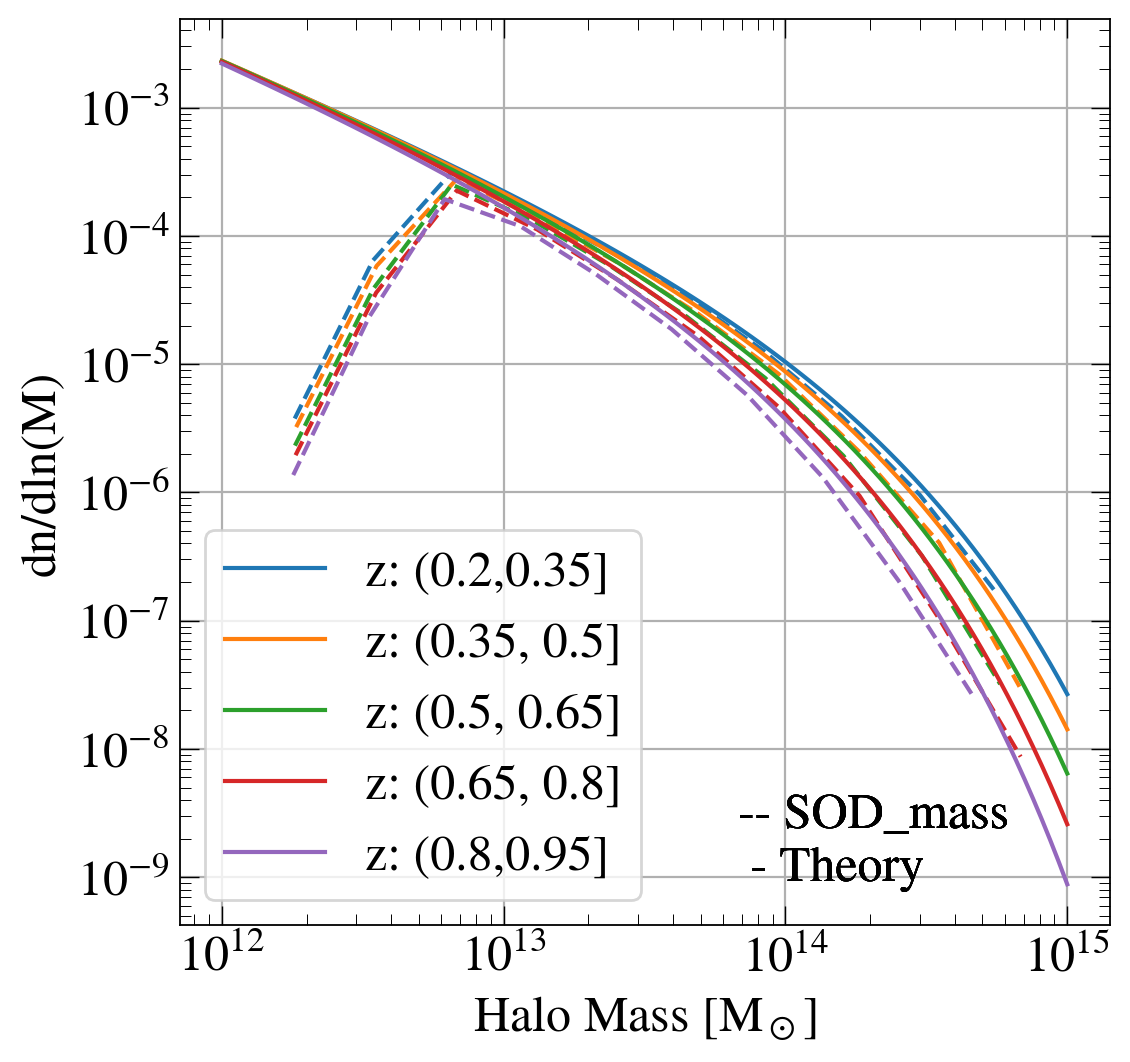

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import re
from colossus.lss import mass_function

grouped_data = sigma_ds_profile2.groupby('redshift_range')

# Create a color map
color_map = plt.cm.get_cmap('tab10')  # Choose a colormap

# Iterate over the groups and plot the data
for idx, (group, data) in enumerate(grouped_data):
    zmin = float(re.findall(r'\d+\.\d+', group)[0])
    zmax = float(re.findall(r'\d+\.\d+', group)[1])
    vol_hiMpc3 = (5000 / (4 * np.pi * ((180 / np.pi) ** 2))) * (4 * np.pi / 3) * (
            (cosmo.comovingDistance(z_max=zmax)) ** 3 - (cosmo.comovingDistance(z_max=zmin)) ** 3)
    M200c = data['baseDC2/sod_halo_mass'] * h
    lnM_all = np.array(np.log(M200c))
    counts, bins = np.histogram(lnM_all)
    bins_mid = (bins[1:] + bins[:-1]) / 2.
    counts = counts / (bins[1] - bins[0])
    vol = vol_hiMpc3
    color = color_map(idx % color_map.N)  # Get a color from the colormap

    plt.plot(np.exp(bins_mid), (counts / vol), color=color, linestyle='--')

    redshift = data['redshift'].mean() #data['redshift'].max()+0.045
    M_plot = np.logspace(12, 15, 100)
    mfunc_200c = mass_function.massFunction(M_plot, redshift, q_out='dndlnM',
                                            mdef='200c', model='tinker08')
    plt.plot(M_plot, mfunc_200c, color=color, label='z')

    # Add text description
    text = f'-- SOD_mass \n - Theory'
    plt.text(0.6, 0.05, text, transform=plt.gca().transAxes)

# Set custom labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = [f'{label}: {group}' for label, group in zip(labels, grouped_data.groups.keys())]


plt.yscale('log')
plt.xscale('log')
plt.xlabel('$\mathrm{Halo ~ Mass ~ [M}_\odot]$')
plt.ylabel('dn/dln(M)')
plt.legend(handles, custom_labels)
# plt.savefig('Images/HaloMassFxn.png', facecolor='white')
plt.show()


### Narrow bins of HMF

In [42]:
sigma_ds_profile2 = pd.read_pickle(file_path + 'WL-Signal/skysim-full-2152757-1.1.1.csv')
sigma_ds_profile2 = sigma_ds_profile2[(sigma_ds_profile2['redshift']<=0.81) & (sigma_ds_profile2['baseDC2/sod_halo_mass']>0)]
sigma_ds_profile2 = sigma_ds_profile2.reset_index(drop=True)


zranges = [(0.2, 0.21), (0.35, 0.36), (0.5, 0.51), (0.65, 0.66), (0.8, 0.81)]
zlabels = ['(0.2,0.21]', '(0.35, 0.36]', '(0.5, 0.51]', '(0.65, 0.66]', '(0.8, 0.81]']
sigma_ds_profile2['redshift_range'] = pd.cut(sigma_ds_profile2['redshift'], bins=pd.IntervalIndex.from_tuples(zranges), labels=zlabels)

sigma_ds_profile2 = sigma_ds_profile2.dropna()

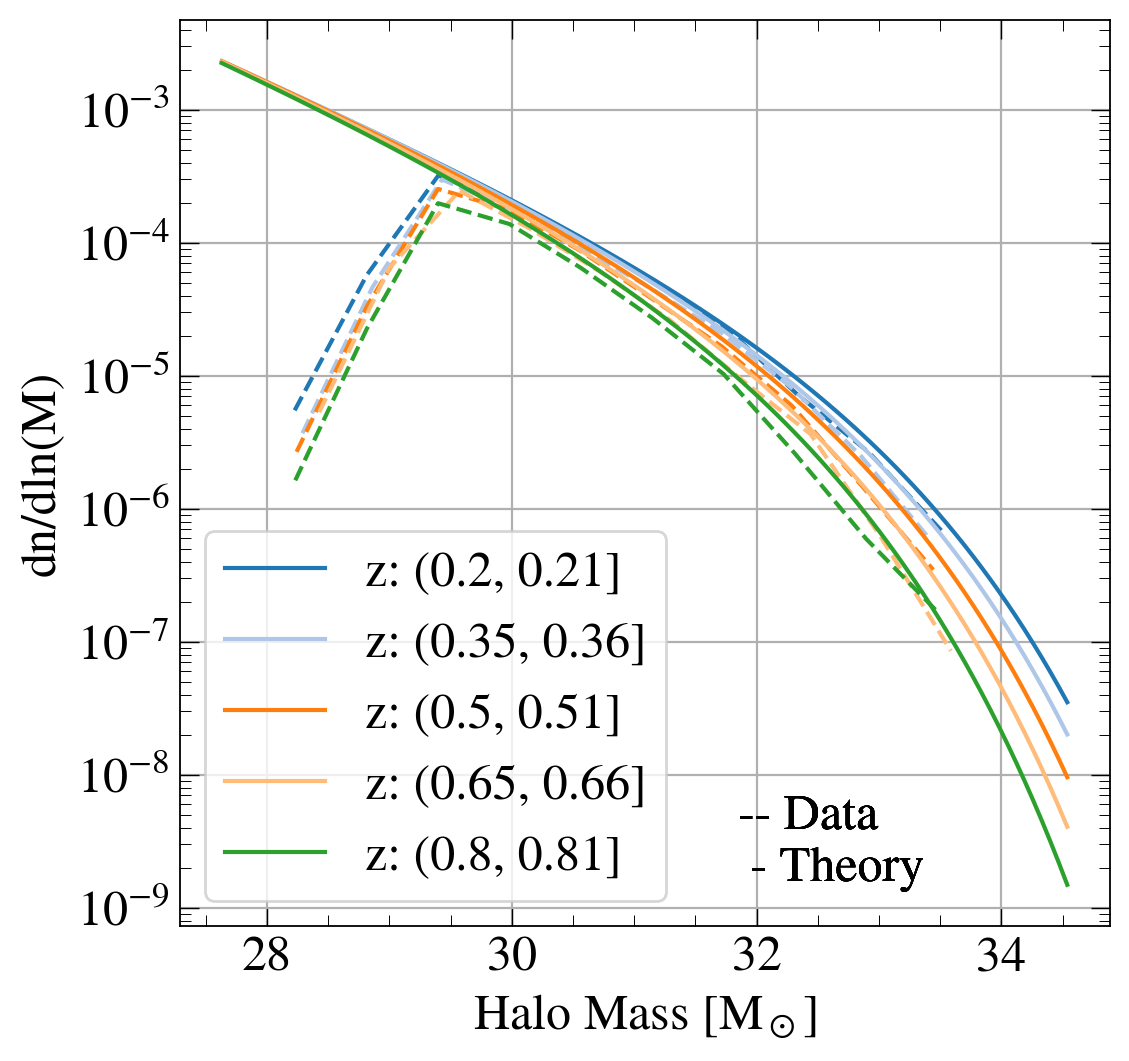

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import re
from colossus.lss import mass_function

grouped_data = sigma_ds_profile2.groupby('redshift_range')

# Create a color map
color_map = plt.cm.get_cmap('tab20')  # Choose a colormap

# Iterate over the groups and plot the data
for idx, (group, data) in enumerate(grouped_data):
    group = str(group)
    zmin = float(re.findall(r'\d+\.\d+', group)[0])
    zmax = float(re.findall(r'\d+\.\d+', group)[1])
    vol_hiMpc3 = (5000 / (4 * np.pi * ((180 / np.pi) ** 2))) * (4 * np.pi / 3) * (
            (cosmo.comovingDistance(z_max=zmax)) ** 3 - (cosmo.comovingDistance(z_max=zmin)) ** 3)
    M200c = data['baseDC2/sod_halo_mass'] * h
    lnM_all = np.array(np.log(M200c))
    counts, bins = np.histogram(lnM_all)
    bins_mid = (bins[1:] + bins[:-1]) / 2.
    counts = counts / (bins[1] - bins[0])
    vol = vol_hiMpc3
    color = color_map(idx % color_map.N)  # Get a color from the colormap

    plt.plot(bins_mid, (counts / vol), color=color, linestyle='--')

    redshift = data['redshift'].mean() #data['redshift'].max()+0.035
    M_plot = np.logspace(12, 15, 100)
    mfunc_200c = mass_function.massFunction(M_plot, redshift, q_out='dndlnM',
                                            mdef='200c', model='tinker08')
    plt.plot(np.log(M_plot), mfunc_200c, color=color, label='z')

    # Add text description
    text = f'-- Data \n - Theory'
    plt.text(0.6, 0.05, text, transform=plt.gca().transAxes)

# Set custom labels for the legend
handles, labels = plt.gca().get_legend_handles_labels()
custom_labels = [f'{label}: {group}' for label, group in zip(labels, grouped_data.groups.keys())]


plt.yscale('log')
plt.xlabel('$\mathrm{Halo ~ Mass ~ [M}_\odot]$')
plt.ylabel('dn/dln(M)')
plt.legend(handles, custom_labels, loc='best')
plt.savefig('Images/HaloMassFxn.png', facecolor='white')
plt.show()
